<a href="https://colab.research.google.com/github/SushmaRajagopal/miRNA-Disease-Association-Prediction-using-Hybrid-Model/blob/main/mirna_disease_association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.9 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import shap

# Step 1: Load datasets
mirna_names = pd.read_csv('/content/miRNA_name.txt', header=None).squeeze()  # List of miRNAs
disease_names = pd.read_csv('/content/disease_name.txt', sep='\t', header=None, names=["index", "DOID", "DiseaseName"])  # Disease list
miRNA_disease_assoc = pd.read_csv('/content/miRNA_disease association.txt', delim_whitespace=True, header=None)  # miRNA-disease association

# Step 2: Data Preprocessing
# Assign miRNA names as the index and disease names as columns
miRNA_disease_assoc.columns = disease_names['DiseaseName']
miRNA_disease_assoc.index = mirna_names

In [ ]:
# Step 3: Flatten the miRNA-disease association matrix into a dataset
miRNA_disease_flattened = miRNA_disease_assoc.stack().reset_index(name='Association')  # Set a new name for the 'Association' column
miRNA_disease_flattened.columns = ['miRNA', 'Disease', 'Association']  # Rename to match 'miRNA', 'Disease', and 'Association'


In [ ]:
# Step 4: One-Hot Encode categorical features (miRNA and Disease)
X = pd.get_dummies(miRNA_disease_flattened[['miRNA', 'Disease']], drop_first=True)

# Convert boolean to integer (ensure all columns are numeric)
X = X.astype(int)

# Target variable 'y' should be numeric as well
y = miRNA_disease_flattened['Association'].astype(int)

# Step 5: Balance the dataset using SMOTE (now with numeric data in X)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [ ]:
# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)



In [ ]:
# XGBoost model for feature extraction
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict using XGBoost to feed into MLP
xgb_train_preds = xgb_model.predict_proba(X_train)[:, 1]
xgb_test_preds = xgb_model.predict_proba(X_test)[:, 1]

# MLP as final classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(xgb_train_preds.reshape(-1, 1), y_train)

# Use MLP to make predictions on the test set
y_pred = mlp_model.predict(xgb_test_preds.reshape(-1, 1))

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:22:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.862639934730563
Precision: 0.8879416819915471
Recall: 0.862639934730563
F1 Score: 0.8603978303524504


In [ ]:
# Step 8: Model Evaluation
mlp_preds = mlp_model.predict(xgb_test_preds.reshape(-1, 1))

# ROC AUC Score and F1 Score
roc_auc = roc_auc_score(y_test, mlp_preds)
f1 = f1_score(y_test, mlp_preds)
print(f'ROC AUC Score: {roc_auc:.2f}')
print(f'F1 Score: {f1:.2f}')

ROC AUC Score: 0.86
F1 Score: 0.88


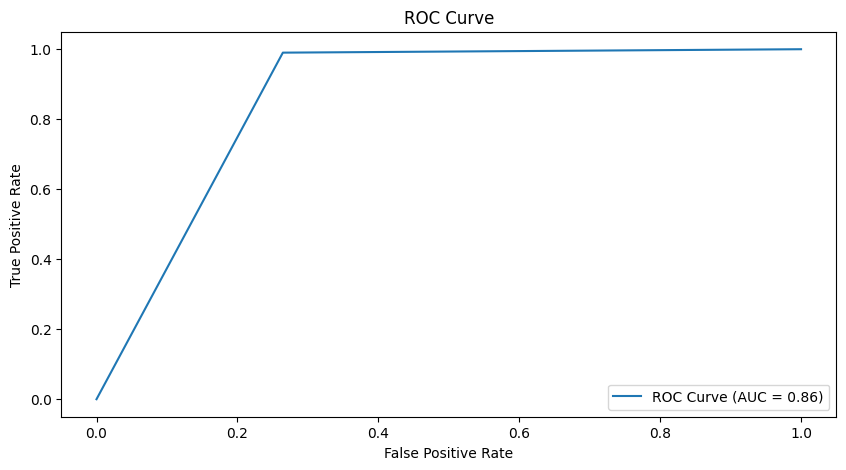

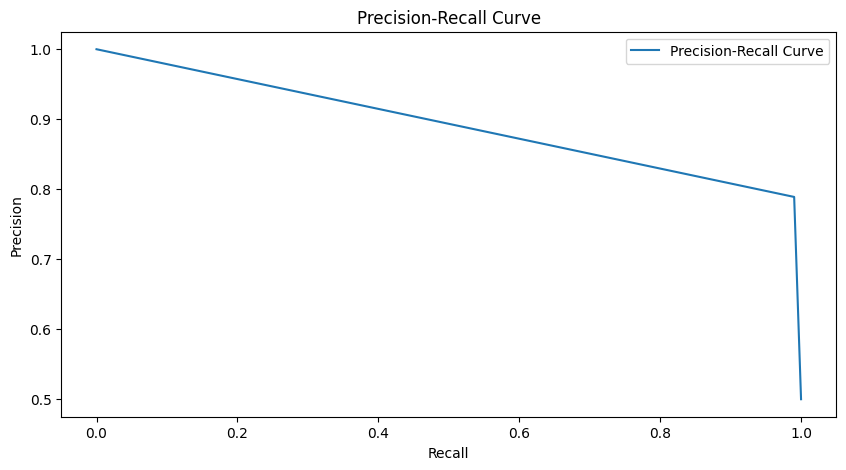

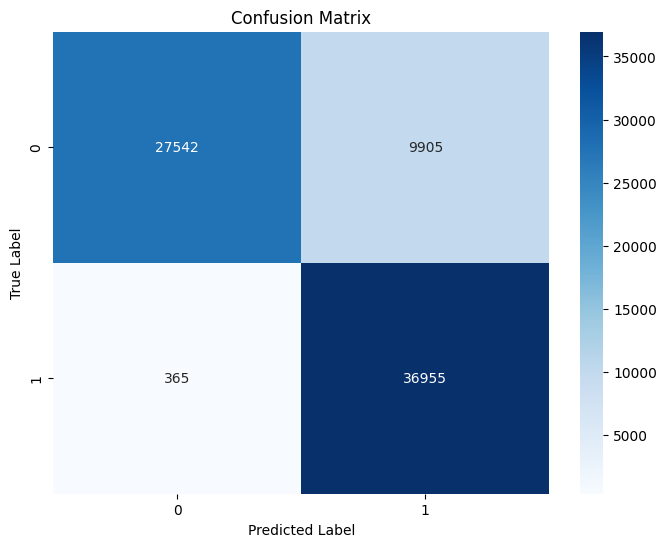

In [ ]:
# Step 9: Visualization - ROC Curve, Precision-Recall Curve, and Confusion Matrix
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, mlp_preds)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, mlp_preds)
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, mlp_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# We are using SHAP (SHapley Additive exPlanations) to interpret the model's predictions by measuring the impact of each feature (diseases and miRNAs) on the model's output.
# SHAP provides insights into how much each feature contributed to a given prediction, helping to explain the relationship between miRNAs and diseases.
# Higher SHAP values for a feature indicate a stronger influence on the model's prediction. In this case, it shows how well a particular disease or miRNA is associated with predicting disease-miRNA interactions.


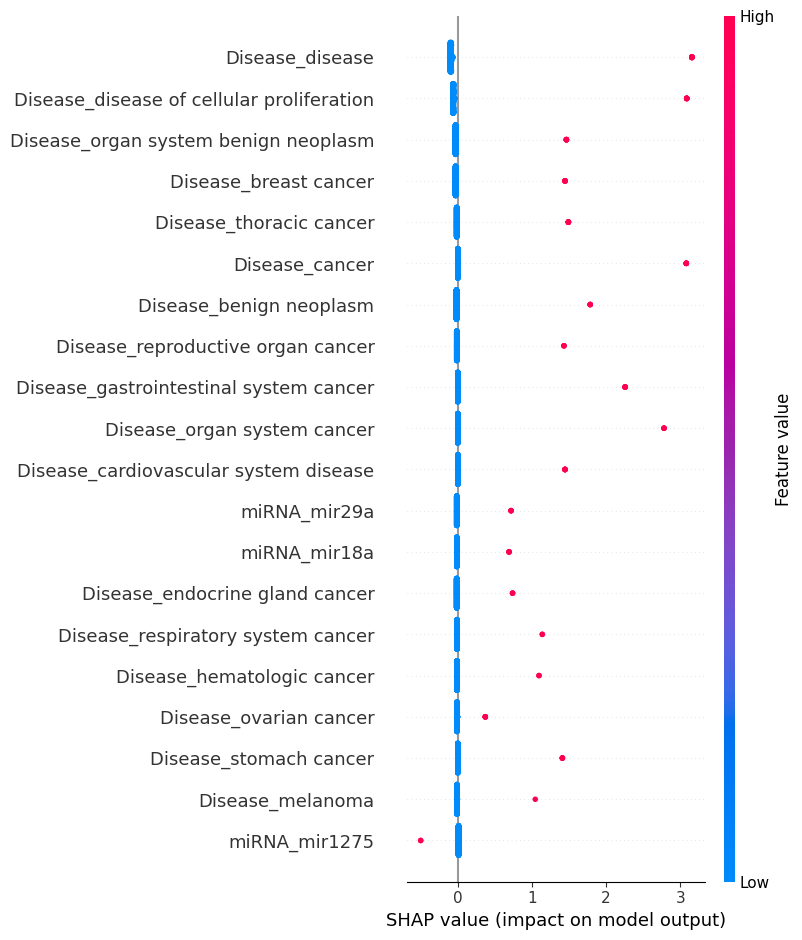

In [ ]:
# Limit the size of X_train for SHAP to avoid memory overload
X_train_sample = X_train.sample(n=500, random_state=42)  # Use a random sample of 500 rows from the training data

# Step 10: SHAP for Explainability (XGBoost Model)
explainer = shap.Explainer(xgb_model, X_train_sample)  # Use the smaller sample for SHAP
shap_values = explainer(X_train_sample)

# SHAP summary plot to show feature importance (on the smaller dataset)
shap.summary_plot(shap_values, X_train_sample)
